In [1]:
import json
import warnings

import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, minmax_scale
from torch.utils.data import DataLoader, Dataset

from models.main import get_model, train_model
from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted
)

In [2]:
BALL_POSSESSION_SPEED = 0.05 #Temp parameter

In [3]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


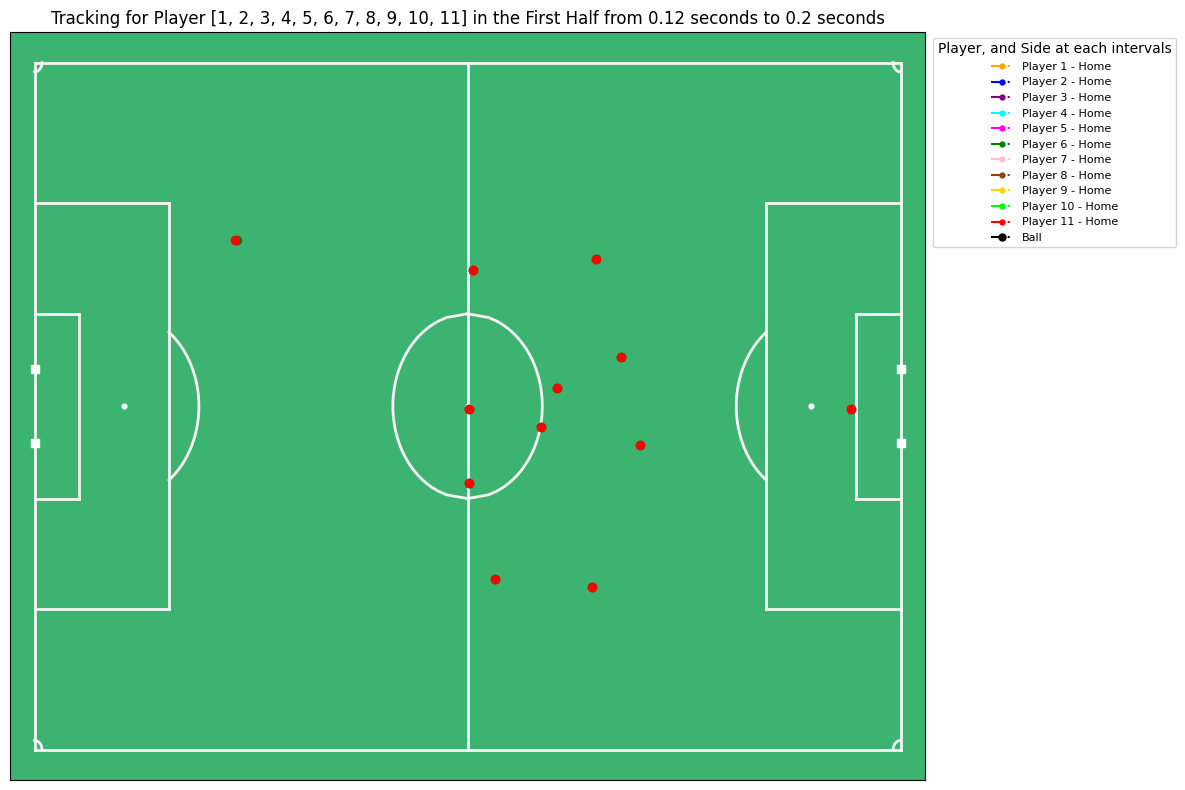

In [7]:
game_2_pre.player_visualization(game_2_data.iloc[2:5], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=True)

# Tracking players closest to the ball using frames

In [8]:
vel_acc_game_1_data = calculate_velocity_acceleration(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration(game_2_data)

In [9]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [10]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[:, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[:, "P_11_velocity":]

assert game_1_players.shape[0] == game_1_ball.shape[0] == game_1_vel_acc.shape[0]
assert game_2_players.shape[0] == game_2_ball.shape[0] == game_2_vel_acc.shape[0]

In [11]:
game_1_vel_acc

,P_11_velocity,P_11_acceleration,P_1_velocity,P_1_acceleration,P_2_velocity,P_2_acceleration,P_3_velocity,P_3_acceleration,P_4_velocity,P_4_acceleration,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003500,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,0.004500,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,0.001750,-0.068750,0.006619,0.165478,0.031445,0.786135,0.007558,0.188953,0.005397,0.134919,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,0.002000,0.006250,0.013530,0.172774,0.009451,-0.549872,0.006576,-0.024541,0.020555,0.378951,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.020239,0.033536,0.000000,0.000000,0.006915,-0.034893,0.001581,0.030690,0.000000,0.000000,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,0.016000,-0.105980,0.000000,0.000000,0.008385,0.036765,0.004031,0.061250,0.000000,0.000000,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,0.014500,-0.037500,0.000000,0.000000,0.010124,0.043474,0.008062,0.100778,0.000000,0.000000,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,0.009003,-0.137413,0.000000,0.000000,0.009280,-0.021097,0.013551,0.137214,0.000000,0.000000,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [12]:
game_1_result = calculate_player_ball_distances(
    game_data=game_1_data,
    player_data=game_1_players,
    ball_data=game_1_ball
)
game_2_result = calculate_player_ball_distances(
    game_data=game_2_data,
    player_data=game_2_players,
    ball_data=game_2_ball
)

In [13]:
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
1,0.04,0.463795,0.295416,0.155454,0.148886,0.219595,0.341617,0.098830,0.088441,0.175352,...,0.220884,0.235846,0.436262,0.232928,0.000000,0.309003,0.107827,0.558025,0.337539,0.136614
2,0.08,0.501257,0.299551,0.179323,0.194075,0.261277,0.330581,0.107148,0.132807,0.199417,...,0.217031,0.190031,0.399390,0.226727,0.046049,0.278446,0.061778,0.536677,0.361474,0.177678
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,5800.08,1.030643,0.414143,0.469161,0.427928,0.108863,0.458256,0.459833,0.506856,0.217931,...,0.453870,0.458256,0.100171,0.287968,0.264367,0.450826,0.191770,0.571092,0.572771,0.550123
145003,5800.12,1.030100,0.414143,0.469075,0.427821,0.108863,0.457754,0.459853,0.506856,0.217704,...,0.454683,0.457754,0.100171,0.287968,0.264367,0.451005,0.191925,0.570647,0.572911,0.550732
145004,5800.16,1.029607,0.414143,0.468928,0.427927,0.108863,0.457372,0.459966,0.506856,0.217345,...,0.454959,0.457372,0.100171,0.287968,0.264367,0.451111,0.191945,0.570399,0.573038,0.550836
145005,5800.20,1.029296,0.414143,0.468838,0.427892,0.108863,0.456586,0.460186,0.506856,0.216806,...,0.455336,0.456586,0.100171,0.287968,0.264367,0.452243,0.191742,0.569931,0.572866,0.550754


In [14]:
game_2_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
1,0.04,0.440590,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
2,0.08,0.440590,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
3,0.12,0.440590,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
4,0.16,0.440590,0.262111,0.191014,0.203496,0.294844,0.364348,0.104851,0.087024,0.248831,...,0.359512,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
5,0.20,0.440590,0.262111,0.191014,0.203496,0.294844,0.364963,0.104851,0.087024,0.248831,...,0.359768,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603386,0.602958,0.989591,...,0.081458,0.493244,0.641833,0.649969,0.583007,0.450188,1.090450,0.456393,0.672318,0.169162
141153,5646.12,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603189,0.602958,0.990306,...,0.081458,0.492950,0.642163,0.649860,0.583427,0.450188,1.090471,0.456189,0.672318,0.169162
141154,5646.16,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.602523,0.602958,0.991150,...,0.081458,0.492180,0.642544,0.650310,0.583837,0.450188,1.090486,0.455554,0.672318,0.169162
141155,5646.20,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.601309,0.602958,0.991955,...,0.081458,0.489952,0.642961,0.650757,0.584248,0.450188,1.090506,0.455871,0.672318,0.169162


In [15]:
idx = game_1_result.min(axis=1).round(4)
game_1_closest_to_ball = get_n_smallest_indices_sorted(game_1_result.iloc[:, 1:], 22)

idx = game_2_result.min(axis=1).round(4)
game_2_closest_to_ball = get_n_smallest_indices_sorted(game_2_result.iloc[:, 1:], 22)
# print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, game_2_closest_to_ball, idx)))

In [16]:
game_1_closest_to_ball

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
1,Away-Player19,Home-Player9,Home-Player7,Home-Player6,Home-Player10,Away-Player21,Away-Player24,Home-Player3,Home-Player2,Home-Player8,...,Away-Player18,Away-Player16,Home-Player1,Away-Player20,Away-Player23,Home-Player5,Away-Player17,Away-Player25,Home-Player11,Away-Player22
2,Home-Player9,Away-Player19,Home-Player10,Away-Player21,Home-Player6,Home-Player7,Away-Player24,Home-Player2,Away-Player16,Home-Player3,...,Away-Player18,Home-Player4,Away-Player20,Home-Player1,Home-Player5,Away-Player23,Away-Player17,Away-Player25,Home-Player11,Away-Player22
3,Home-Player10,Away-Player21,Home-Player9,Away-Player19,Home-Player6,Away-Player16,Home-Player7,Home-Player2,Away-Player24,Away-Player15,...,Home-Player3,Away-Player20,Home-Player4,Home-Player1,Home-Player5,Away-Player17,Away-Player25,Away-Player23,Away-Player22,Home-Player11
4,Home-Player10,Away-Player21,Home-Player9,Away-Player19,Away-Player16,Home-Player6,Home-Player7,Away-Player15,Home-Player2,Away-Player24,...,Home-Player3,Away-Player20,Home-Player4,Home-Player1,Home-Player5,Away-Player25,Away-Player17,Away-Player23,Away-Player22,Home-Player11
5,Home-Player10,Away-Player21,Home-Player9,Away-Player19,Away-Player16,Home-Player6,Home-Player7,Away-Player15,Home-Player8,Away-Player24,...,Away-Player18,Away-Player20,Home-Player4,Home-Player1,Home-Player5,Away-Player25,Away-Player23,Away-Player17,Away-Player22,Home-Player11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19,Home-Player9,Away-Player18,Home-Player1,Home-Player3,Away-Player20,...,Away-Player16,Home-Player5,Home-Player6,Home-Player2,Home-Player10,Home-Player7,Away-Player24,Away-Player22,Away-Player23,Home-Player11
145003,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19,Home-Player9,Away-Player18,Home-Player1,Home-Player3,Away-Player20,...,Away-Player16,Home-Player5,Home-Player6,Home-Player2,Home-Player10,Home-Player7,Away-Player24,Away-Player22,Away-Player23,Home-Player11
145004,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19,Home-Player9,Away-Player18,Home-Player1,Home-Player3,Away-Player20,...,Away-Player16,Home-Player5,Home-Player6,Home-Player2,Home-Player10,Home-Player7,Away-Player24,Away-Player22,Away-Player23,Home-Player11
145005,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19,Home-Player9,Away-Player18,Home-Player1,Home-Player3,Away-Player20,...,Away-Player16,Home-Player5,Home-Player6,Home-Player2,Home-Player10,Home-Player7,Away-Player24,Away-Player22,Away-Player23,Home-Player11


In [17]:
game_2_closest_to_ball

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
1,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20,Away-Player24,Home-Player2,Away-Player16,Away-Player21,Home-Player9,...,Away-Player18,Home-Player8,Home-Player1,Home-Player4,Away-Player15,Home-Player5,Away-Player19,Home-Player11,Away-Player25,Away-Player22
2,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20,Away-Player24,Home-Player2,Away-Player16,Away-Player21,Home-Player9,...,Away-Player18,Home-Player8,Home-Player1,Home-Player4,Away-Player15,Home-Player5,Away-Player19,Home-Player11,Away-Player25,Away-Player22
3,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20,Away-Player24,Home-Player2,Away-Player16,Away-Player21,Home-Player9,...,Away-Player18,Home-Player8,Home-Player1,Home-Player4,Away-Player15,Home-Player5,Away-Player19,Home-Player11,Away-Player25,Away-Player22
4,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20,Away-Player24,Home-Player2,Away-Player16,Away-Player21,Home-Player9,...,Away-Player18,Home-Player8,Home-Player1,Home-Player4,Away-Player15,Home-Player5,Away-Player19,Home-Player11,Away-Player25,Away-Player22
5,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20,Away-Player24,Home-Player2,Away-Player16,Away-Player21,Home-Player9,...,Away-Player18,Home-Player8,Home-Player1,Home-Player4,Away-Player15,Home-Player5,Away-Player19,Home-Player11,Away-Player25,Away-Player22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1,Home-Player3,Home-Player9,Home-Player10,Away-Player20,Away-Player22,...,Away-Player19,Home-Player7,Home-Player6,Away-Player17,Away-Player18,Home-Player11,Away-Player23,Away-Player25,Home-Player8,Away-Player21
141153,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1,Home-Player3,Home-Player9,Home-Player10,Away-Player20,Away-Player22,...,Away-Player19,Home-Player7,Home-Player6,Away-Player17,Away-Player18,Home-Player11,Away-Player23,Away-Player25,Home-Player8,Away-Player21
141154,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1,Home-Player3,Home-Player9,Home-Player10,Away-Player20,Away-Player22,...,Away-Player19,Home-Player6,Home-Player7,Away-Player17,Away-Player18,Home-Player11,Away-Player23,Away-Player25,Home-Player8,Away-Player21
141155,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1,Home-Player3,Home-Player9,Home-Player10,Away-Player20,Away-Player22,...,Away-Player19,Home-Player6,Home-Player7,Away-Player17,Away-Player18,Home-Player11,Away-Player23,Away-Player25,Home-Player8,Away-Player21


In [18]:
temp_game_1_data = game_1_data.copy()
temp_game_2_data = game_2_data.copy()

temp_game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
temp_game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]

In [19]:
temp_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,-0.55236,-0.43313,-0.50034,-0.94391,-0.43644,-0.05038,-0.37756,-0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,-0.55202,-0.43311,-0.50017,-0.94434,-0.43580,-0.04977,-0.37663,-0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,-0.10317,-0.81976,-0.19836,-0.45137,-0.29416,-0.48874,-0.35600,-0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,-0.10319,-0.81960,-0.19831,-0.45182,-0.29373,-0.48836,-0.35583,-0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,-0.10285,-0.81944,-0.19805,-0.45200,-0.29331,-0.48800,-0.35561,-0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,-0.10231,-0.81944,-0.19766,-0.45237,-0.29272,-0.48789,-0.35532,-0.55243,0.03058,0.99726


In [23]:
%time game_1_min_dist_to_ball = track_closest_players(game_data=temp_game_1_data, closest_players=game_1_closest_to_ball)

CPU times: total: 18.3 s
Wall time: 18.8 s


In [24]:
game_1_min_dist_to_ball

,Time [s],Ball-x,Ball-y,P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_18-x,P_18-y,P_19-x,P_19-y,P_20-x,P_20-y,P_21-x,P_21-y,P_22-x,P_22-y
1,0.04,0.45472,0.38709,-0.45472,-0.38709,0.52697,0.37980,0.39125,0.32550,0.41698,...,0.41094,0.72589,-0.67310,-0.76476,-0.90509,-0.47462,0.00082,0.48238,-0.50067,-0.94322
2,0.08,0.49645,0.40656,0.52697,0.37980,-0.45472,-0.38709,0.55243,0.43269,-0.55243,...,-0.43693,-0.05002,-0.67310,-0.76476,-0.90494,-0.47462,0.00096,0.48238,-0.50067,-0.94322
3,0.12,0.53716,0.42556,0.55243,0.43269,-0.55243,-0.43269,0.52697,0.37980,-0.45472,...,-0.67310,-0.76476,-0.90434,-0.47463,-0.43693,-0.05002,-0.50067,-0.94322,0.00114,0.48238
4,0.16,0.55346,0.42231,0.55236,0.43313,-0.55236,-0.43313,0.52731,0.38010,-0.45454,...,-0.90377,-0.47463,-0.67279,-0.76542,-0.43644,-0.05038,-0.50034,-0.94391,0.00121,0.48238
5,0.20,0.55512,0.40570,0.55202,0.43311,-0.55202,-0.43311,0.52737,0.37991,-0.45426,...,-0.90324,-0.47464,-0.43580,-0.04977,-0.67253,-0.76564,-0.50017,-0.94434,0.00129,0.48238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,5800.08,0.03058,0.99726,-0.09880,-0.92391,0.11428,0.92765,-0.10317,-0.81976,0.17443,...,0.37398,0.62446,-0.35600,-0.55371,-0.19836,-0.45137,-0.29416,-0.48874,0.90614,0.45355
145003,5800.12,0.03058,0.99726,-0.09880,-0.92391,0.11428,0.92765,-0.10319,-0.81960,0.17428,...,0.37398,0.62446,-0.35583,-0.55283,-0.19831,-0.45182,-0.29373,-0.48836,0.90550,0.45355
145004,5800.16,0.03058,0.99726,-0.09880,-0.92391,0.11428,0.92765,-0.10285,-0.81944,0.17401,...,0.37398,0.62446,-0.35561,-0.55254,-0.19805,-0.45200,-0.29331,-0.48800,0.90492,0.45355
145005,5800.20,0.03058,0.99726,-0.09880,-0.92391,0.11428,0.92765,-0.10231,-0.81944,0.17358,...,0.37398,0.62446,-0.35532,-0.55243,-0.19766,-0.45237,-0.29272,-0.48789,0.90456,0.45356


In [25]:
%time game_2_min_dist_to_ball = track_closest_players(game_data=temp_game_2_data, closest_players=game_2_closest_to_ball)

CPU times: total: 17.4 s
Wall time: 17.6 s


In [26]:
game_2_min_dist_to_ball

,Time [s],Ball-x,Ball-y,P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_18-x,P_18-y,P_19-x,P_19-y,P_20-x,P_20-y,P_21-x,P_21-y,P_22-x,P_22-y
1,0.04,0.50216,0.50376,-0.50177,-0.50145,0.58508,0.53017,0.60269,0.47397,0.50194,...,0.23339,0.25869,-0.49564,-0.91364,0.94275,0.50413,-0.01218,-0.51763,-0.49889,0.02263
2,0.08,0.50216,0.50376,-0.50177,-0.50145,0.58508,0.53017,0.60269,0.47397,0.50194,...,0.23339,0.25869,-0.49564,-0.91364,0.94275,0.50413,-0.01218,-0.51763,-0.49889,0.02263
3,0.12,0.50216,0.50376,-0.50177,-0.50145,0.58508,0.53017,0.60269,0.47397,0.50194,...,0.23339,0.25869,-0.49564,-0.91364,0.94275,0.50413,-0.01218,-0.51763,-0.49889,0.02263
4,0.16,0.50216,0.50376,-0.50177,-0.50145,0.58508,0.53017,0.60269,0.47397,0.50194,...,0.23254,0.25870,-0.49564,-0.91364,0.94275,0.50413,-0.01218,-0.51763,-0.49889,0.02263
5,0.20,0.50216,0.50376,-0.50177,-0.50145,0.58508,0.53017,0.60269,0.47397,0.50194,...,0.23170,0.25871,-0.49564,-0.91364,0.94275,0.50413,-0.01218,-0.51763,-0.49889,0.02263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.40958,-0.03891,-0.49028,0.05000,0.40592,0.08002,-0.36760,-0.12496,0.40837,...,0.06285,0.51243,-0.26855,-0.61845,-0.91211,-0.48311,0.51032,0.94554,-0.46751,-1.05000
141153,5646.12,0.40958,-0.03891,-0.49028,0.05000,0.40592,0.08002,-0.36760,-0.12496,0.40837,...,0.06285,0.51243,-0.26855,-0.61845,-0.91191,-0.48311,0.51031,0.94626,-0.46790,-1.05000
141154,5646.16,0.40958,-0.03891,-0.49028,0.05000,0.40592,0.08002,-0.36760,-0.12496,0.40837,...,0.06285,0.51243,-0.26855,-0.61845,-0.91168,-0.48311,0.51029,0.94711,-0.46818,-1.05000
141155,5646.20,0.40958,-0.03891,-0.49028,0.05000,0.40592,0.08002,-0.36760,-0.12496,0.40837,...,0.06285,0.51243,-0.26855,-0.61845,-0.91151,-0.48311,0.51028,0.94792,-0.46855,-1.05000


In [ ]:
delete_idx = game_1_vel_acc[game_1_vel_acc["Ball_velocity"] > BALL_POSSESSION_SPEED].index
game_1_min_dist_to_ball = game_1_min_dist_to_ball.loc[~game_1_min_dist_to_ball.index.isin(delete_idx), :]

In [ ]:
delete_idx = game_2_vel_acc[game_2_vel_acc["Ball_velocity"] > BALL_POSSESSION_SPEED].index
game_2_min_dist_to_ball = game_2_min_dist_to_ball.loc[~game_2_min_dist_to_ball.index.isin(delete_idx), :]

In [ ]:
game_2_min_dist_to_ball

In [36]:
temp = list(game_2_min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1))
sides = []
player_col = []
size = len(temp)
for i in range(size):
    end = 12
    if len(temp[i]) == 15:
        end = 13
    player_col.append(temp[i][11:end])
    sides.append(temp[i][:4])

In [37]:
def get_changes(lst: list[str]):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
            
    return change_nums, change_indices

def get_items(lst: list[int], lst2: list[str]):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [38]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_game_2_min_dist_to_ball = game_2_min_dist_to_ball.iloc[idxs, :]

In [39]:
dif_game_2_min_dist_to_ball.index[10:45]

Index([], dtype='int64')

In [48]:
smaller_dataset = game_1_min_dist_to_ball.loc[142259:142394]

In [68]:
assert len(dif_game_2_min_dist_to_ball) == len(dif_player_col)

In [49]:
smaller_dataset

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
142259,5690.40,0.96569,0.57932,0.56019,0.55588,0.56784,0.47331,0.56940,0.53597,0.44241,0.29381,0.966220,0.473380
142260,5690.44,0.96488,0.57869,0.55992,0.55566,0.56735,0.47353,0.56976,0.53618,0.44252,0.29350,0.961870,0.477450
142261,5690.48,0.96411,0.57807,0.55967,0.55544,0.56686,0.47375,0.57011,0.53638,0.44261,0.29317,0.957510,0.481510
142262,5690.52,0.96339,0.57746,0.55943,0.55522,0.56638,0.47397,0.57043,0.53661,0.44270,0.29282,0.953150,0.485570
142263,5690.56,0.96271,0.57685,0.55921,0.55501,0.56592,0.47419,0.57070,0.53683,0.44277,0.29250,0.948800,0.489630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142390,5695.64,0.44497,0.46795,0.33078,0.51781,0.56238,0.98624,0.92088,0.85842,0.90013,0.89803,0.395470,1.005580
142391,5695.68,0.44507,0.46802,0.33021,0.51850,0.56262,0.98789,0.92111,0.86049,0.90119,0.89861,0.391110,1.009640
142392,5695.72,0.44520,0.46808,0.32963,0.51921,0.56288,0.98950,0.92133,0.86255,0.90226,0.89919,0.386750,1.013700
142393,5695.76,0.44541,0.46812,0.32905,0.51993,0.56316,0.99109,0.92154,0.86459,0.90329,0.89975,0.382400,1.017770


In [50]:
import copy
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import Metrica_IO as mio
import Metrica_Viz as mviz
from config import Config
_config = Config()
_colors = _config.COLOR_MAP
def player_visualiz(
             dataset: pd.DataFrame, players: list[int] = [11], 
            sides: list[str] = ["Home"], marker_size: int = 7,
            plot_ball: bool = True, use_annotation: bool = False
    ) -> None:
        fig, ax = mviz.plot_pitch()
        ball_is_not_there = plot_ball

        title = "Player, and Side at each intervals"
        if use_annotation:
            title = "Player, and Frame at each intervals"

        for i, (player, side) in enumerate(zip(players, sides)):
            x = f"P_{player}-x"
            y = f"P_{player}-y"

            # Prepare player positions and their coordinates on the pitch
            data_x = pd.to_numeric(dataset[x], errors='coerce')
            data_y = pd.to_numeric(dataset[y], errors='coerce')

            # Create DataFrames with a single column for x and y coordinate of a player
            positions_x = pd.DataFrame(data_x, columns=[x])
            positions_y = pd.DataFrame(data_y, columns=[y])

            # Changing the dataset to metric or pitch coordinates
            positions_x = mio.to_metric_coordinates(positions_x)
            positions_y = mio.to_metric_coordinates(positions_y)

            color = _colors[i % len(_colors)]

            # Plot player movement with arrows
            for j in range(len(positions_x) - 1):
                dx = positions_x[x].iloc[j + 1] - positions_x[x].iloc[j]
                dy = positions_y[y].iloc[j + 1] - positions_y[y].iloc[j]

                if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                    ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2,
                             fc=color, ec=color, linestyle="dotted", length_includes_head=True)

            # Plot the player path with dots and lines
            if use_annotation:
                for i in range(len(positions_x)):
                    ax.plot(positions_x[x].iloc[i], positions_y[y].iloc[i], marker=".", linestyle="-.",
                            markersize=marker_size, color=color, zorder=3,
                            label=f"P{use_annotation[i]} - {positions_x.index[i]}")
                    ax.text(positions_x[x].iloc[i], positions_y[y].iloc[i], positions_x.index[i], fontsize=12,
                            ha='right')
            else:
                ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=marker_size, color=color,
                        zorder=3, label=f"Player {player} - {side}")
            
            ax.plot(positions_x[x].iloc[0], positions_y[y].iloc[0], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="green", zorder=3)
            ax.plot(positions_x[x].iloc[-1], positions_y[y].iloc[-1], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="red", zorder=3)

        # ax.annotate("Start Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate("End Point", (positions_x[x].iloc[-1], positions_y[y].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)

        if ball_is_not_there:
            ba_x = pd.to_numeric(dataset["Ball-x"], errors='coerce')
            ba_y = pd.to_numeric(dataset["Ball-y"], errors='coerce')

            ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["Ball-x"]))
            ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["Ball-y"]))

            ax.plot(ba_x["Ball-x"], ba_y["Ball-y"], marker=".", linestyle="-.", markersize=int(marker_size * 1.5),
                    color="black", zorder=2, label="Ball")
            ax.plot(ba_x["Ball-x"].iloc[0], ba_y["Ball-y"].iloc[0], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="green", zorder=2)
            ax.plot(ba_x["Ball-x"].iloc[-1], ba_y["Ball-y"].iloc[-1], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="red", zorder=2)

            # Ball movement arrows
            for j in range(len(ba_x) - 1):
                dx = ba_x["Ball-x"].iloc[j + 1] - ba_x["Ball-x"].iloc[j]
                dy = ba_y["Ball-y"].iloc[j + 1] - ba_y["Ball-y"].iloc[j]
                if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                    ax.arrow(ba_x["Ball-x"].iloc[j], ba_y["Ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2,
                             fc='black', ec='black', linestyle="dotted", length_includes_head=True)

        # ax.annotate("Start Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        # ax.annotate("End Point", (ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")

        start_seconds = dataset["Time [s]"].iloc[0]
        end_seconds = dataset["Time [s]"].iloc[-1]
        pl = [i for i in players]
        ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {end_seconds} seconds")

        ax.legend(title=title, loc="upper right", bbox_to_anchor=(1.28, 1), fontsize=8)

        plt.tight_layout()
        plt.show()

In [107]:
smaller_dataset

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
142258,5690.36,0.96655,0.57996,0.56046,0.55611,0.56834,0.47308,0.56907,0.53575,0.44233,0.29415,0.967430,0.472870
142259,5690.40,0.96569,0.57932,0.56019,0.55588,0.56784,0.47331,0.56940,0.53597,0.44241,0.29381,0.966220,0.473380
142260,5690.44,0.96488,0.57869,0.55992,0.55566,0.56735,0.47353,0.56976,0.53618,0.44252,0.29350,0.961870,0.477450
142261,5690.48,0.96411,0.57807,0.55967,0.55544,0.56686,0.47375,0.57011,0.53638,0.44261,0.29317,0.957510,0.481510
142262,5690.52,0.96339,0.57746,0.55943,0.55522,0.56638,0.47397,0.57043,0.53661,0.44270,0.29282,0.953150,0.485570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142390,5695.64,0.44497,0.46795,0.33078,0.51781,0.56238,0.98624,0.92088,0.85842,0.90013,0.89803,0.395470,1.005580
142391,5695.68,0.44507,0.46802,0.33021,0.51850,0.56262,0.98789,0.92111,0.86049,0.90119,0.89861,0.391110,1.009640
142392,5695.72,0.44520,0.46808,0.32963,0.51921,0.56288,0.98950,0.92133,0.86255,0.90226,0.89919,0.386750,1.013700
142393,5695.76,0.44541,0.46812,0.32905,0.51993,0.56316,0.99109,0.92154,0.86459,0.90329,0.89975,0.382400,1.017770


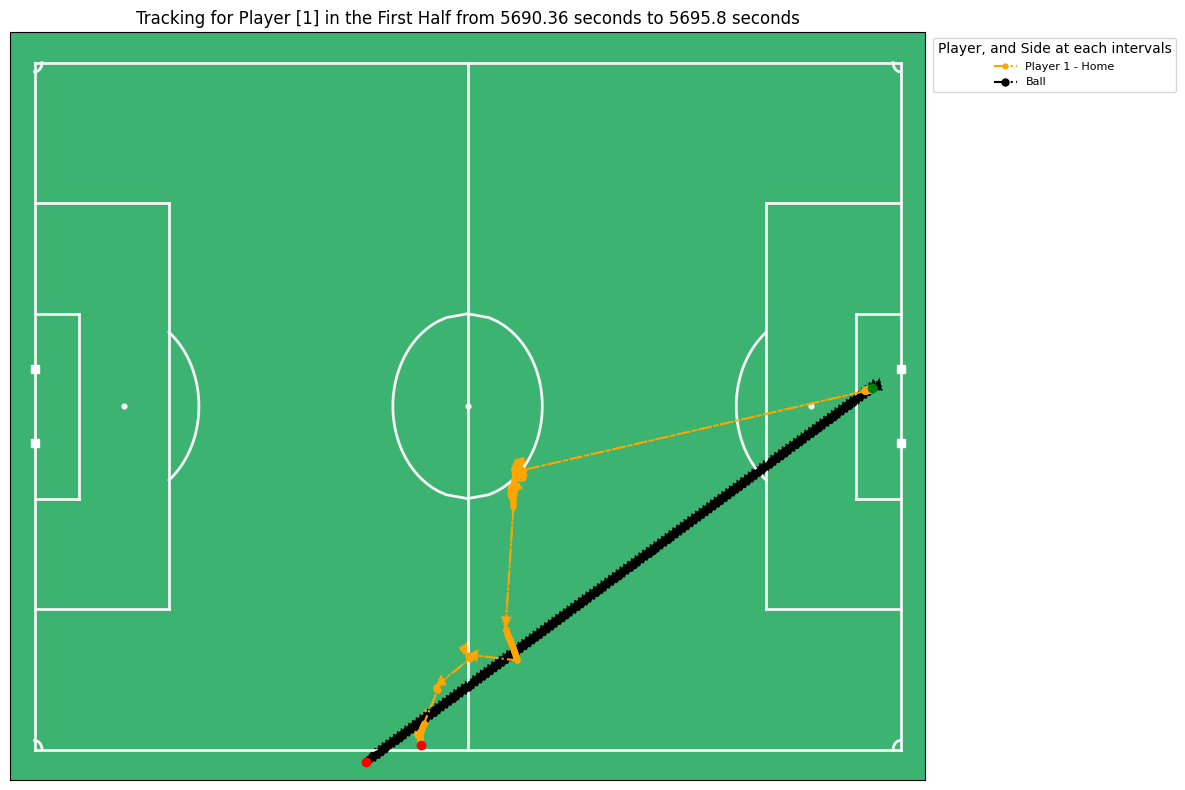

In [74]:
player_visualiz(smaller_dataset, plot_ball=True, players=[1], use_annotation=None, sides=["Home"]*1) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Classification

In [27]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

game_1_event_data = game_1_event_data[~(game_1_event_data["Type"] == "FAULT RECEIVED")]
game_2_event_data = game_2_event_data[~(game_2_event_data["Type"] == "FAULT RECEIVED")]

game_1_event_data = game_1_event_data.replace("RECOVERY", "BALL LOST")
game_2_event_data = game_2_event_data.replace("RECOVERY", "BALL LOST")

game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [28]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [29]:
game_2_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,51,51,Player23,NaN
1,PASS,51,87,Player23,Player20
2,PASS,146,186,Player20,Player18
3,PASS,248,283,Player18,Player17
4,PASS,316,346,Player17,Player16
...,...,...,...,...,...
1930,BALL LOST,140122,140183,Player21,NaN
1931,CHALLENGE,140180,140180,Player1,NaN
1932,CHALLENGE,140183,140183,Player24,NaN
1933,BALL LOST,140211,140211,Player12,NaN


In [30]:
game_1_event = process_event_data(game_1_event_data, game_1_data)
game_2_event = process_event_data(game_2_event_data, game_2_data)

In [31]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [32]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [33]:
common_indices = game_1_event.index.intersection(game_1_min_dist_to_ball.index)
X_1 = game_1_min_dist_to_ball.loc[common_indices]
X_1 = X_1.iloc[:, 1:]
y_1 = game_1_event.loc[common_indices, "Type"]

In [34]:
common_indices = game_2_event.index.intersection(game_2_min_dist_to_ball.index)
X_2 = game_2_min_dist_to_ball.loc[common_indices]
X_2 = X_2.iloc[:, 1:]
y_2 = game_2_event.loc[common_indices, "Type"]

In [35]:
X_1

,Ball-x,Ball-y,P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,P_4-y,...,P_18-x,P_18-y,P_19-x,P_19-y,P_20-x,P_20-y,P_21-x,P_21-y,P_22-x,P_22-y
1,0.45472,0.38709,-0.45472,-0.38709,0.52697,0.37980,0.39125,0.32550,0.41698,0.47843,...,0.41094,0.72589,-0.67310,-0.76476,-0.90509,-0.47462,0.00082,0.48238,-0.50067,-0.94322
2,0.49645,0.40656,0.52697,0.37980,-0.45472,-0.38709,0.55243,0.43269,-0.55243,-0.43269,...,-0.43693,-0.05002,-0.67310,-0.76476,-0.90494,-0.47462,0.00096,0.48238,-0.50067,-0.94322
3,0.53716,0.42556,0.55243,0.43269,-0.55243,-0.43269,0.52697,0.37980,-0.45472,-0.38709,...,-0.67310,-0.76476,-0.90434,-0.47463,-0.43693,-0.05002,-0.50067,-0.94322,0.00114,0.48238
4,0.55346,0.42231,0.55236,0.43313,-0.55236,-0.43313,0.52731,0.38010,-0.45454,-0.38818,...,-0.90377,-0.47463,-0.67279,-0.76542,-0.43644,-0.05038,-0.50034,-0.94391,0.00121,0.48238
5,0.55512,0.40570,0.55202,0.43311,-0.55202,-0.43311,0.52737,0.37991,-0.45426,-0.38725,...,-0.90324,-0.47464,-0.43580,-0.04977,-0.67253,-0.76564,-0.50017,-0.94434,0.00129,0.48238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.08382,0.62709,-0.08695,-0.63646,-0.05685,-0.61336,0.11104,0.67714,0.11746,0.55166,...,-0.45370,-0.49248,0.47196,0.44820,0.50936,0.57808,0.47277,0.28266,0.87621,0.48890
143615,0.08062,0.62314,-0.08490,-0.63798,-0.05564,-0.61495,0.11004,0.67616,0.11681,0.55129,...,-0.45319,-0.49318,0.47157,0.44844,0.50890,0.57796,0.47218,0.28291,0.87601,0.48911
143616,0.07743,0.61919,-0.08286,-0.63948,-0.05444,-0.61653,0.10914,0.67526,0.11620,0.55099,...,-0.45268,-0.49386,0.47120,0.44872,0.50844,0.57788,0.47161,0.28324,0.87583,0.48933
143617,0.07423,0.61523,-0.05326,-0.61815,-0.08087,-0.64102,0.10829,0.67433,0.11559,0.55068,...,-0.45220,-0.49465,0.47084,0.44899,0.50799,0.57768,0.47105,0.28354,0.87564,0.48954


# New Dataset

In [36]:
game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)

In [37]:
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)

In [38]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,NaN,NaN


In [39]:
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)
# game_3_data.iloc[:, 24:-2] = -1 * game_3_data.iloc[:, 24:-2]
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


In [40]:
vel_acc_game_3_data = calculate_velocity_acceleration(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [41]:
game_3_players, game_3_ball, game_3_vel_acc = vel_acc_game_3_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_3_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_3_data.loc[:, "P_11_velocity":]

assert game_3_players.shape[0] == game_3_ball.shape[0] == game_3_vel_acc.shape[0]
game_3_result = calculate_player_ball_distances(
    game_data=game_3_data,
    player_data=game_3_players,
    ball_data=game_2_ball
)
game_3_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
1,0.04,0.345949,0.296834,0.167490,0.198936,0.326533,0.346425,0.117999,0.050620,0.156541,...,0.335484,0.286503,0.211337,0.328784,0.133013,0.091589,0.087345,0.163815,0.230614,0.140840
2,0.08,0.345949,0.299056,0.167104,0.198738,0.325710,0.349409,0.118933,0.048323,0.155089,...,0.334882,0.285628,0.211964,0.333108,0.131623,0.091620,0.088605,0.168629,0.230479,0.140820
3,0.12,0.345949,0.299976,0.166983,0.198502,0.325712,0.349677,0.119137,0.047149,0.154698,...,0.334342,0.285571,0.212174,0.334694,0.131193,0.091997,0.088930,0.169453,0.230678,0.140740
4,0.16,0.345949,0.300680,0.167028,0.198158,0.325606,0.350975,0.118839,0.045620,0.154505,...,0.334221,0.285315,0.212258,0.335887,0.131063,0.092431,0.089071,0.170727,0.230987,0.141696
5,0.20,0.345949,0.300877,0.166995,0.197829,0.325691,0.350903,0.118761,0.043912,0.154566,...,0.334233,0.285270,0.212888,0.336314,0.131508,0.092720,0.089416,0.170881,0.231135,0.142083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,5750.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143758,5750.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143759,5750.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143760,5750.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
idx = game_3_result.min(axis=1).round(4)
game_3_closest_to_ball = get_n_smallest_indices_sorted(game_3_result.iloc[:, 1:], 22)
game_3_closest_to_ball

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
1,Home-Player10,Home-Player7,Away-Player21,Away-Player20,Home-Player6,Away-Player19,Away-Player24,Home-Player8,Away-Player22,Home-Player2,...,Away-Player23,Home-Player9,Away-Player16,Home-Player1,Home-Player4,Away-Player18,Away-Player15,Home-Player11,Home-Player5,Away-Player25
2,Home-Player10,Home-Player7,Away-Player21,Away-Player20,Home-Player6,Away-Player19,Away-Player24,Home-Player8,Home-Player2,Away-Player22,...,Away-Player23,Home-Player9,Away-Player16,Home-Player1,Home-Player4,Away-Player18,Away-Player15,Home-Player11,Home-Player5,Away-Player25
3,Home-Player10,Home-Player7,Away-Player21,Away-Player20,Home-Player6,Away-Player19,Away-Player24,Home-Player8,Home-Player2,Away-Player22,...,Away-Player23,Home-Player9,Away-Player16,Home-Player1,Home-Player4,Away-Player15,Away-Player18,Home-Player11,Home-Player5,Away-Player25
4,Home-Player10,Home-Player7,Away-Player21,Away-Player20,Home-Player6,Away-Player19,Away-Player24,Home-Player8,Home-Player2,Away-Player22,...,Away-Player23,Home-Player9,Away-Player16,Home-Player1,Home-Player4,Away-Player15,Away-Player18,Home-Player11,Home-Player5,Away-Player25
5,Home-Player10,Home-Player7,Away-Player21,Away-Player20,Home-Player6,Away-Player19,Away-Player24,Home-Player8,Home-Player2,Away-Player22,...,Away-Player23,Home-Player9,Away-Player16,Home-Player1,Home-Player4,Away-Player15,Away-Player18,Home-Player11,Home-Player5,Away-Player25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,Home-Player11,Away-Player22,Away-Player21,Away-Player20,Away-Player19,Away-Player18,Away-Player17,Away-Player16,Away-Player15,Away-Player25,...,Home-Player8,Home-Player7,Home-Player6,Home-Player5,Home-Player4,Home-Player3,Home-Player2,Home-Player1,Away-Player23,Away-Player24
143758,Home-Player11,Away-Player22,Away-Player21,Away-Player20,Away-Player19,Away-Player18,Away-Player17,Away-Player16,Away-Player15,Away-Player25,...,Home-Player8,Home-Player7,Home-Player6,Home-Player5,Home-Player4,Home-Player3,Home-Player2,Home-Player1,Away-Player23,Away-Player24
143759,Home-Player11,Away-Player22,Away-Player21,Away-Player20,Away-Player19,Away-Player18,Away-Player17,Away-Player16,Away-Player15,Away-Player25,...,Home-Player8,Home-Player7,Home-Player6,Home-Player5,Home-Player4,Home-Player3,Home-Player2,Home-Player1,Away-Player23,Away-Player24
143760,Home-Player11,Away-Player22,Away-Player21,Away-Player20,Away-Player19,Away-Player18,Away-Player17,Away-Player16,Away-Player15,Away-Player25,...,Home-Player8,Home-Player7,Home-Player6,Home-Player5,Home-Player4,Home-Player3,Home-Player2,Home-Player1,Away-Player23,Away-Player24


In [43]:
temp_game_3_data = game_3_data.copy()
temp_game_3_data.iloc[:, 24:-2] = -1 * game_3_data.iloc[:, 24:-2]

%time game_3_min_dist_to_ball = track_closest_players(game_data=temp_game_3_data, closest_players=game_3_closest_to_ball)
game_3_min_dist_to_ball

CPU times: total: 18 s
Wall time: 18.5 s


,Time [s],Ball-x,Ball-y,P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,...,P_18-x,P_18-y,P_19-x,P_19-y,P_20-x,P_20-y,P_21-x,P_21-y,P_22-x,P_22-y
1,0.04,0.50125,0.48725,0.50555,0.50863,0.50212,0.45314,-0.41787,-0.48086,-0.41381,...,-0.32492,-0.22684,-0.34297,-0.79907,0.84722,0.52855,0.50533,0.15735,-0.08110,-0.49705
2,0.08,0.50125,0.48725,0.50545,0.50532,0.50158,0.45544,-0.41719,-0.47864,-0.41375,...,-0.32400,-0.22230,-0.34200,-0.79786,0.84722,0.52855,0.50461,0.15436,-0.08110,-0.49705
3,0.12,0.50125,0.48725,0.50552,0.50524,0.50126,0.45662,-0.41697,-0.47824,-0.41371,...,-0.34137,-0.79690,-0.32353,-0.22072,0.84722,0.52855,0.50430,0.15409,-0.08110,-0.49705
4,0.16,0.50125,0.48725,0.50563,0.50524,0.50119,0.45815,-0.41685,-0.47815,-0.41370,...,-0.34102,-0.79657,-0.32307,-0.21960,0.84722,0.52855,0.50394,0.15279,-0.08110,-0.49705
5,0.20,0.50125,0.48725,0.50576,0.50531,0.50114,0.45986,-0.41669,-0.47749,-0.41369,...,-0.34085,-0.79649,-0.32300,-0.21914,0.84722,0.52855,0.50371,0.15286,-0.08110,-0.49705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,5750.28,0.89207,0.50485,0.11993,0.51783,-0.50218,-0.65158,-0.58877,-0.56936,-0.54552,...,0.46373,0.62102,0.49691,0.77311,0.47808,0.45408,-0.46978,-0.62349,-0.80792,-0.27106
143758,5750.32,0.89207,0.50485,0.11993,0.51783,-0.50180,-0.65115,-0.58787,-0.56961,-0.54533,...,0.46381,0.62046,0.49701,0.77429,0.47786,0.45521,-0.46970,-0.62403,-0.80712,-0.27184
143759,5750.36,0.89207,0.50485,0.11993,0.51783,-0.50116,-0.65071,-0.58668,-0.57038,-0.54486,...,0.46358,0.62117,0.49686,0.77555,0.47743,0.45709,-0.46929,-0.62479,-0.80582,-0.27242
143760,5750.40,0.89207,0.50485,0.11993,0.51783,-0.50031,-0.65134,-0.58525,-0.57033,-0.54422,...,0.46306,0.62339,0.49676,0.77638,0.47669,0.45947,-0.46866,-0.62611,-0.80444,-0.27260


In [44]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [45]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    if t != "CARRY" and t != "BALL OUT":
        type_ = np.append(type_, t)
        start_frame = np.append(start_frame, sf)
        end_frame = np.append(end_frame, ef)


game_3_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [46]:
game_3_event_data = game_3_event_data[~(game_3_event_data["Type"] == "FAULT RECEIVED")]

game_3_event_data = game_3_event_data.replace("RECOVERY", "BALL LOST")
game_3_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,PASS,384,426
3,PASS,465,507
4,PASS,530,580
...,...,...,...
2156,PASS,143190,143265
2157,PASS,143265,143290
2158,PASS,143406,143469
2159,PASS,143469,143532


In [47]:
game_3_event = process_event_data(game_3_event_data, game_3_data)
game_3_event

,Type
361,PASS
362,PASS
363,PASS
364,PASS
365,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [48]:
common_indices = game_3_event.index.intersection(game_3_min_dist_to_ball.index)
X_3 = game_3_min_dist_to_ball.loc[common_indices]
X_3 = X_3.iloc[:, 1:]
y_3 = game_3_event.loc[common_indices, "Type"]

assert X_3.shape[0] == y_3.shape[0]

In [49]:
X_3

,Ball-x,Ball-y,P_1-x,P_1-y,P_2-x,P_2-y,P_3-x,P_3-y,P_4-x,P_4-y,...,P_18-x,P_18-y,P_19-x,P_19-y,P_20-x,P_20-y,P_21-x,P_21-y,P_22-x,P_22-y
361,0.50125,0.48725,-0.31093,-0.61000,-0.41598,-0.54809,-0.29696,-0.41736,-0.41560,-0.47430,...,0.71661,0.65952,0.73474,0.38597,0.50242,0.12687,0.63861,0.19465,0.84219,0.51681
362,0.50111,0.48724,-0.31103,-0.61013,-0.41645,-0.54800,-0.29696,-0.41726,-0.41584,-0.47443,...,0.71668,0.65969,0.73488,0.38666,0.50240,0.12631,0.63826,0.19424,0.84232,0.51649
363,0.50095,0.48723,-0.31116,-0.61028,-0.41696,-0.54799,-0.29695,-0.41711,-0.45279,-0.61938,...,0.71673,0.65993,0.73500,0.38738,0.50238,0.12578,0.63792,0.19398,0.84246,0.51620
364,0.50079,0.48721,-0.31130,-0.61038,-0.41749,-0.54794,-0.29698,-0.41698,-0.45307,-0.61917,...,0.71680,0.66012,0.73515,0.38793,0.50238,0.12528,0.63761,0.19364,0.84262,0.51583
365,0.50063,0.48720,-0.31146,-0.61057,-0.41806,-0.54791,-0.29699,-0.41679,-0.45339,-0.61897,...,0.71688,0.66031,0.73530,0.38849,0.50238,0.12480,0.63733,0.19331,0.84282,0.51546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.87713,0.53311,0.11993,0.51783,-0.53056,-0.77445,-0.63498,-0.60528,-0.48388,-0.40934,...,0.43239,0.63392,0.43863,0.79777,0.42811,0.48741,-0.41511,-0.60500,-0.75468,-0.20334
143530,0.87985,0.52767,0.11993,0.51783,-0.53076,-0.77417,-0.63547,-0.60520,-0.48423,-0.40945,...,0.43311,0.63370,0.43895,0.79718,0.42872,0.48704,-0.41543,-0.60508,-0.75576,-0.20261
143531,0.88258,0.52223,0.11993,0.51783,-0.53096,-0.77393,-0.63595,-0.60505,-0.48457,-0.40947,...,0.43382,0.63342,0.43928,0.79654,0.42932,0.48660,-0.41575,-0.60518,-0.75687,-0.20178
143532,0.88531,0.51679,0.11993,0.51783,-0.53114,-0.77364,-0.63642,-0.60491,-0.48493,-0.40951,...,0.43452,0.63314,0.43961,0.79595,0.42993,0.48618,-0.41607,-0.60521,-0.75800,-0.20099


In [50]:
np.unique(np.concatenate((y_1, y_2, y_3)), return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([ 28815,  54180,     11,    498, 103325,     19,   1418],
       dtype=int64))

In [51]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([10042, 19023,     4,   132, 28127,    13,   546], dtype=int64))

In [52]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([ 7713, 15537,     6,   174, 32340,     6,   482], dtype=int64))

In [53]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SHOT'],
       dtype=object),
 array([11060, 19620,     1,   192, 42858,   390], dtype=int64))

In [93]:
best to worst: None, minmax, standard, minmax_scale

SyntaxError: invalid syntax (836642398.py, line 1)

In [68]:
# scaler = MinMaxScaler()
# X_1_scaled = scaler.fit_transform(X_1)
# X_2_scaled = scaler.transform(X_2)
# X_3_scaled = scaler.transform(X_3)

# X_1_scaled = X_1.iloc[:, :].values
# X_2_scaled = X_2.iloc[:, :].values
# X_3_scaled = X_3.iloc[:, :].values

X_1_scaled = minmax_scale(X_1, axis=1)
X_2_scaled = minmax_scale(X_2, axis=1)
X_3_scaled = minmax_scale(X_3, axis=1)

In [69]:
label_encoder = LabelEncoder()
y_1_encoded = y_1.copy()#label_encoder.fit_transform(y_1)
y_2_encoded = y_2.copy()#label_encoder.transform(y_2)
y_3_encoded = y_3.copy()#label_encoder.transform(y_3)

In [56]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57887, 46)
(56258, 46)
(74121, 46)


In [97]:
X_1_scaled = X_1_scaled[:(X_1_scaled.shape[0] - X_1_scaled.shape[0] % 100)]
y_1_encoded = y_1_encoded[:(y_1_encoded.shape[0] - y_1_encoded.shape[0] % 100)]

X_2_scaled = X_2_scaled[:(X_2_scaled.shape[0] - X_2_scaled.shape[0] % 100)]
y_2_encoded = y_2_encoded[:(y_2_encoded.shape[0] - y_2_encoded.shape[0] % 100)]

X_3_scaled = X_3_scaled[:(X_3_scaled.shape[0] - X_3_scaled.shape[0] % 100)]
y_3_encoded = y_3_encoded[:(y_3_encoded.shape[0] - y_3_encoded.shape[0] % 100)]

In [70]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57887, 46)
(56258, 46)
(74121, 46)


In [71]:
X = np.concatenate([X_1_scaled, X_2_scaled])
y = np.concatenate((y_1_encoded, y_2_encoded))

assert X.shape[0] == y.shape[0]

In [72]:
models = {
      # "AdaBoost classifier": AdaBoostClassifier(random_state=42), 
      # "Logistic regression": LogisticRegression(solver="saga", random_state=42),
      # "Gaussian naive bayes": GaussianNB(),
      "Random forest classifier": RandomForestClassifier(n_jobs=-1), 
      # "Neural network": MLPClassifier(hidden_layer_sizes=(32, 32, 32, 16, 16,), learning_rate="adaptive", random_state=42), 
    }

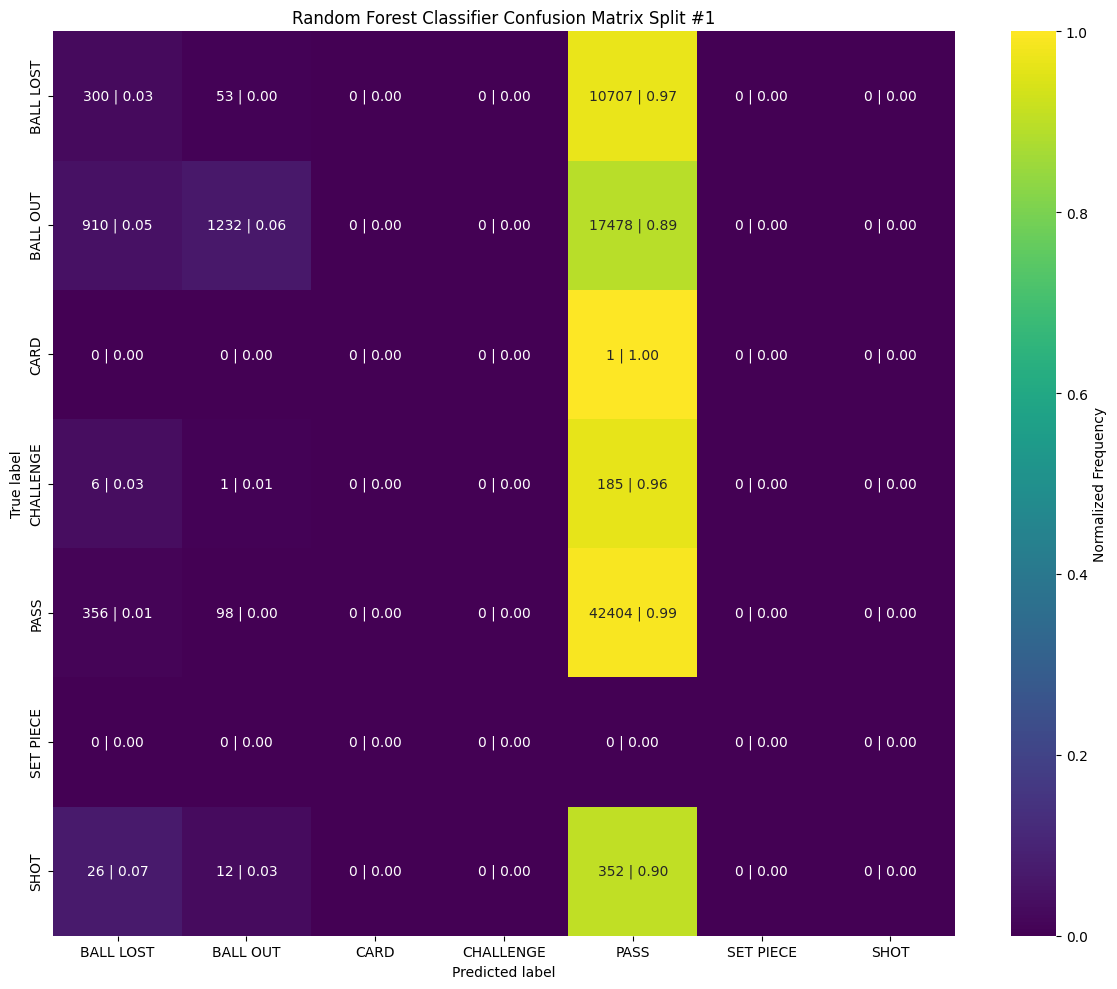

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 59.28%

Random forest classifier testing precision: 60.63%
Random forest classifier testing recall: 59.28%
Random forest classifier testing f1: 46.83%




In [73]:
# for i in range(len(scaled["X_train"])):
for name, model in models.items():
    # X_train_scaled = scaled["X_train"][0]
    # X_test_scaled = scaled["X_test"][0]
    # y_train = scaled["y_train"][0]
    # y_test = scaled["y_test"][0]

    model.fit(X, y)
    y_train_pred = model.predict(X)
    y_pred = model.predict(X_3_scaled)    
    labels = np.unique(y)#['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'])
    
    fig_value = plot_confusion_matrix(y_train=y, y_train_pred=y_train_pred, y_test=y_3_encoded, y_pred=y_pred, labels=labels, split=0, model_name=name)
    
    # print("\n")

In [107]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 3060 Laptop GPU


In [108]:
np.unique(y_1).shape, np.unique(y_2).shape

((7,), (7,))

In [109]:
lstm_params = {
    "input_size": X_1_scaled.shape[1],
    "hidden_size" : 256,
    "num_layers" : 2,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.10523009649860546,
}
input_size = X_1_scaled.shape[1]
sequence_length = 50
learning_rate = 0.0012682942484929386
batch_size = 256
num_epochs = 150

In [110]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, sequence_task=True):
        self.features = torch.tensor(features.values if hasattr(features, "values") else features,
                                   dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels,
                                 dtype=torch.long)
        self.sequence_task = sequence_task
        
        # Validate shapes
        assert self.features.shape[0] == self.labels.shape[0], \
            f"Number of samples mismatch: features {self.features.shape[0]}, labels {self.labels.shape[0]}"
        
        if sequence_task:
            assert self.features.shape[1] == self.labels.shape[1], \
                f"Sequence length mismatch: features {self.features.shape[1]}, labels {self.labels.shape[1]}"
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

X_comb = np.concatenate([X_1_scaled, X_2_scaled])
y_comb = np.concatenate((y_1_encoded, y_2_encoded))

X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size)
y_comb_reshaped = y_comb.reshape(-1, sequence_length)

X_3_reshaped = X_3_scaled.reshape(-1, sequence_length, input_size)
y_3_reshaped = y_3_encoded.reshape(-1, sequence_length) 

training_dataset = CustomDataset(X_comb_reshaped, y_comb_reshaped)
validation_dataset = CustomDataset(X_3_reshaped, y_3_reshaped)

train_loader = DataLoader(
    dataset=training_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [111]:
lstm_model = get_model("lstm", lstm_params=lstm_params).to(device)
lstm_model

LSTM(
  (encoder): Encoder(
    (input_bn): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lstm): LSTM(12, 256, num_layers=2, batch_first=True, dropout=0.10523009649860546)
  )
  (decoder): Decoder(
    (lstm): LSTM(7, 256, num_layers=2, batch_first=True, dropout=0.10523009649860546)
    (hidden_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.10523009649860546, inplace=False)
      (4): Linear(in_features=256, out_features=7, bias=True)
    )
  )
)

In [ ]:
acc = train_model(lstm_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_seq_model=True)

Epoch 1/150: Train accuracy: 31.39% | Val accuracy: 34.56% | Train loss: 1.7933 | Val loss: 1.2994 | learning rate: 0.001268 | Precision: 45.54% | Recall: 34.56% | F1: 33.38%
Epoch 2/150: Train accuracy: 49.72% | Val accuracy: 42.54% | Train loss: 1.2491 | Val loss: 2.5015 | learning rate: 0.001268 | Precision: 42.28% | Recall: 42.54% | F1: 40.64%
Epoch 3/150: Train accuracy: 50.43% | Val accuracy: 58.17% | Train loss: 1.1661 | Val loss: 1.1169 | learning rate: 0.001268 | Precision: 47.66% | Recall: 58.17% | F1: 44.73%
Epoch 4/150: Train accuracy: 49.47% | Val accuracy: 57.72% | Train loss: 1.1294 | Val loss: 1.0791 | learning rate: 0.001268 | Precision: 45.55% | Recall: 57.72% | F1: 46.88%
Epoch 5/150: Train accuracy: 51.66% | Val accuracy: 59.15% | Train loss: 1.0936 | Val loss: 1.0468 | learning rate: 0.001268 | Precision: 53.03% | Recall: 59.15% | F1: 46.07%
Epoch 6/150: Train accuracy: 55.00% | Val accuracy: 57.81% | Train loss: 1.0769 | Val loss: 1.1691 | learning rate: 0.001268 

In [97]:
acc = train_model(lstm_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_seq_model=True)

Epoch 1/150: Train accuracy: 21.02% | Val accuracy: 16.82% | Train loss: 2.0790 | Val loss: 3.1539 | learning rate: 0.001268 | Precision: 44.28% | Recall: 16.82% | F1: 13.75%
Epoch 2/150: Train accuracy: 32.72% | Val accuracy: 28.99% | Train loss: 1.6232 | Val loss: 2.1021 | learning rate: 0.001268 | Precision: 42.81% | Recall: 28.99% | F1: 32.19%
Epoch 3/150: Train accuracy: 45.50% | Val accuracy: 56.45% | Train loss: 1.3191 | Val loss: 1.1844 | learning rate: 0.001268 | Precision: 49.00% | Recall: 56.45% | F1: 51.24%
Epoch 4/150: Train accuracy: 54.11% | Val accuracy: 54.02% | Train loss: 1.1638 | Val loss: 1.1511 | learning rate: 0.001268 | Precision: 46.27% | Recall: 54.02% | F1: 48.70%
Epoch 5/150: Train accuracy: 51.99% | Val accuracy: 53.45% | Train loss: 1.1189 | Val loss: 1.2127 | learning rate: 0.001268 | Precision: 44.39% | Recall: 53.45% | F1: 48.40%
Epoch 6/150: Train accuracy: 54.97% | Val accuracy: 56.29% | Train loss: 1.0887 | Val loss: 1.1133 | learning rate: 0.001268 

In [75]:
acc = train_model(lstm_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_seq_model=True)

Epoch 1/150: Train accuracy: 6.83% | Val accuracy: 3.04% | Train loss: 2.4738 | Val loss: 1.9860 | learning rate: 0.001268 | Precision: 0.09% | Recall: 3.04% | F1: 0.18%
Epoch 2/150: Train accuracy: 6.22% | Val accuracy: 3.52% | Train loss: 2.6150 | Val loss: 15.2458 | learning rate: 0.001268 | Precision: 50.80% | Recall: 3.52% | F1: 4.66%
Epoch 3/150: Train accuracy: 10.04% | Val accuracy: 5.57% | Train loss: 2.4056 | Val loss: 9.8950 | learning rate: 0.001268 | Precision: 51.41% | Recall: 5.57% | F1: 8.12%
Epoch 4/150: Train accuracy: 27.39% | Val accuracy: 15.52% | Train loss: 2.2165 | Val loss: 3.6804 | learning rate: 0.001268 | Precision: 8.98% | Recall: 15.52% | F1: 11.32%
Epoch 5/150: Train accuracy: 31.65% | Val accuracy: 17.09% | Train loss: 1.8987 | Val loss: 3.9544 | learning rate: 0.001268 | Precision: 50.21% | Recall: 17.09% | F1: 13.69%
Epoch 6/150: Train accuracy: 41.17% | Val accuracy: 22.91% | Train loss: 1.7284 | Val loss: 1.8728 | learning rate: 0.001268 | Precision:

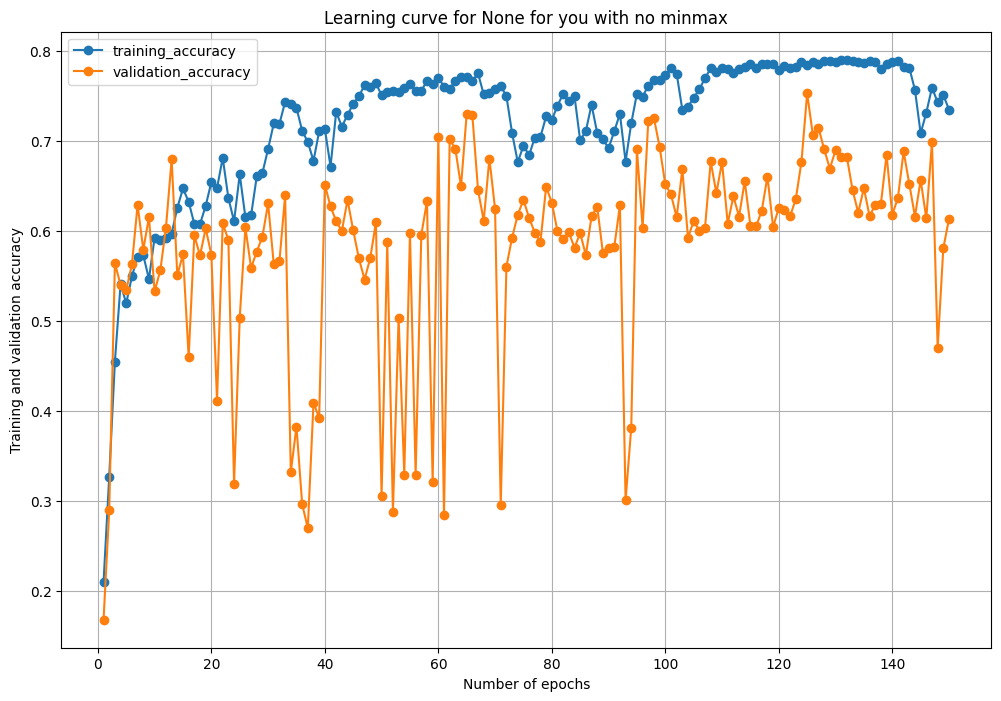

In [98]:
plot_accuracy_history(acc, title="None for you with no minmax")

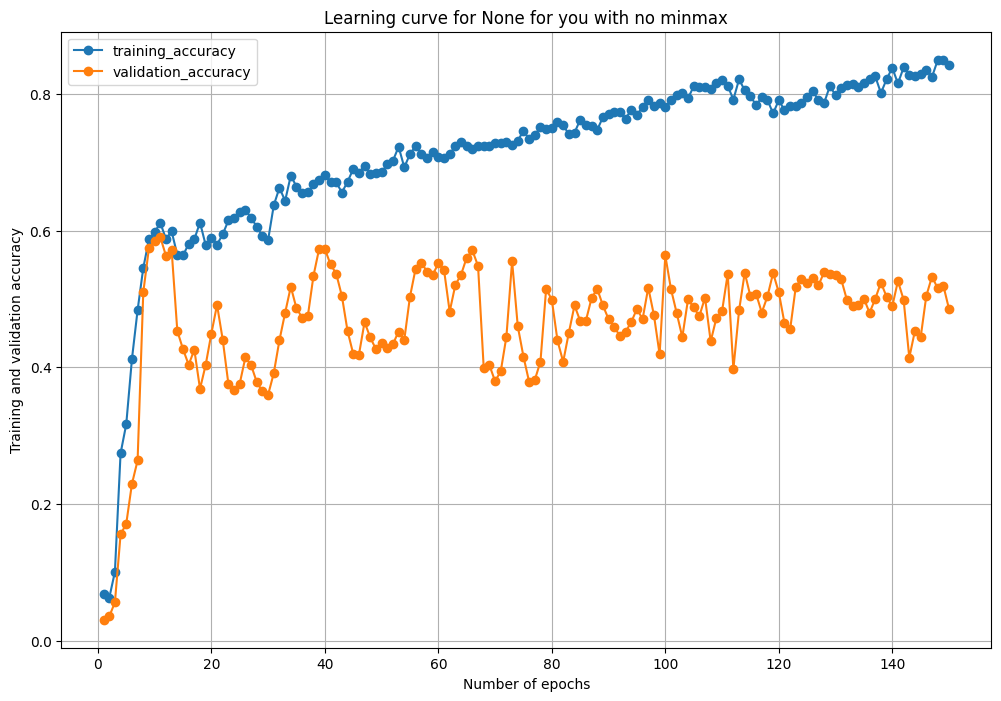

In [76]:
plot_accuracy_history(acc, title="None for you with no minmax")